In [1]:
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from itertools import product
from statsmodels.stats.diagnostic import acorr_ljungbox
from typing import Union
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

# Bi-directional time-series exogenous
In SARIMAX we take into account 
- S : Seasonality (use cyclicity in data to make predictions)
- AR: AutoRegression (use past values to predict the future)
- I : Integration (differentiate to keep the stationarity hypothesis)
- MA: Moving Average (use past average / trend to predict)
- X : eXogenous variable (other variables might influence our time series prediction) 

now we will focus on the VAR model to take into account that other variables are not always exogenous: endogenous might have retro-action on them 

let's see how real disposable income and real consumption affect the other 

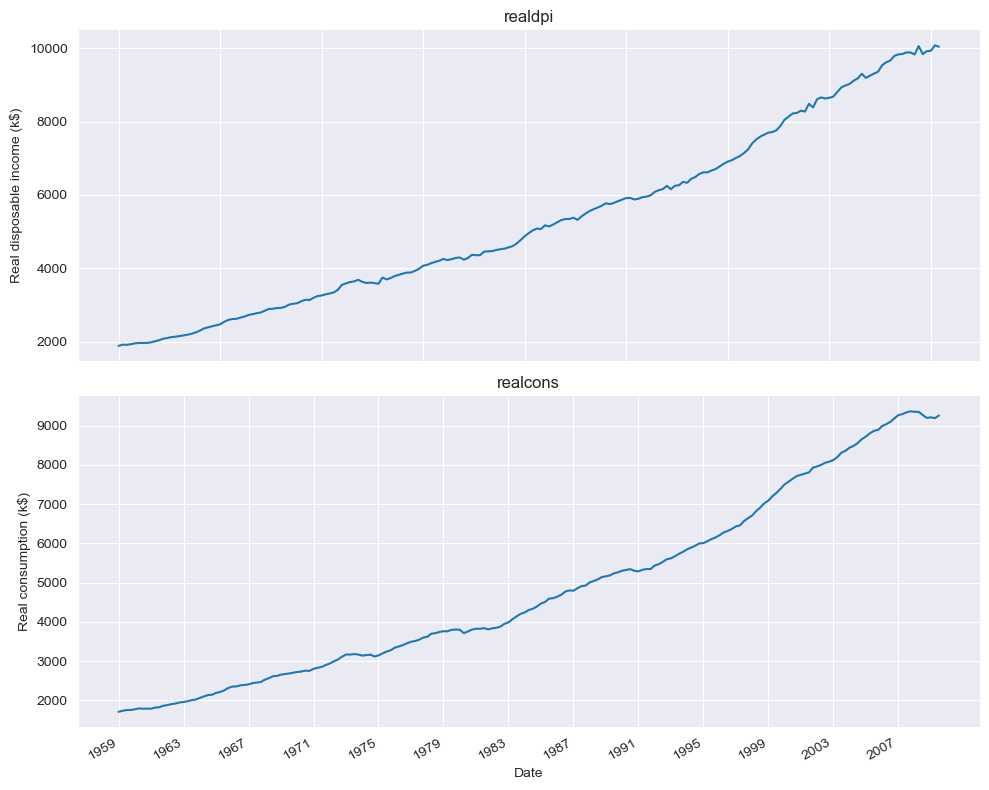

In [2]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income (k$)')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)

ax2.plot(macro_econ_data['realcons'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

they look similar but that is not enough 

In [3]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')

print('\nAfter Differencing---------------------\n')
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'].diff()[1:])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: 2.986025351954683
p-value: 1.0

---------------------

realcons
ADF Statistic: 1.549912338050962

After Differencing---------------------

realdpi
ADF Statistic: -8.864893340673008
p-value: 1.4493606159108096e-14

---------------------

realcons
ADF Statistic: -4.204306080845247
p-value: 0.0006479282158627571


after differencing everything is stationary

In [4]:

def optimize_VAR(endog: Union[pd.Series, list]) -> pd.DataFrame:
    
    results = []
    
    for i in tqdm_notebook(range(15)):
        # noinspection PyBroadException
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue
            
        aic = model.aic
        results.append([i, aic])
        
    result_df_local = pd.DataFrame(results)
    result_df_local.columns = ['p', 'AIC']
    
    result_df_local = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df_local

let's fit the model and find order p=3

In [5]:
endogenous = macro_econ_data[['realdpi', 'realcons']]

endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

train = endog_diff[:162]
test = endog_diff[162:]

result_df = optimize_VAR(train)

  0%|          | 0/15 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.61849D+00    |proj g|=  2.88206D-03

At iterate    5    f=  9.61847D+00    |proj g|=  2.89231D-03


 This problem is unconstrained.



At iterate   10    f=  9.61834D+00    |proj g|=  3.17861D-03

At iterate   15    f=  9.61833D+00    |proj g|=  2.08505D-03

At iterate   20    f=  9.61831D+00    |proj g|=  7.03842D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     21     25      1     0     0   7.094D-05   9.618D+00
  F =   9.6183127883777608     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58116D+00    |proj g|=  4.45022D-03

At iter

 This problem is unconstrained.



At iterate   10    f=  9.58065D+00    |proj g|=  4.18731D-03

At iterate   15    f=  9.58061D+00    |proj g|=  7.55728D-04

At iterate   20    f=  9.58056D+00    |proj g|=  3.53015D-03

At iterate   25    f=  9.58054D+00    |proj g|=  3.50140D-04

At iterate   30    f=  9.58053D+00    |proj g|=  1.10616D-03

At iterate   35    f=  9.58053D+00    |proj g|=  9.40130D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     36     42      1     0     0   6.700D-05   9.581D+00
  F =   9.5805298381602562     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  9.53459D+00    |proj g|=  1.00744D-02

At iterate   15    f=  9.53435D+00    |proj g|=  6.18731D-04

At iterate   20    f=  9.53427D+00    |proj g|=  6.00966D-03

At iterate   25    f=  9.53419D+00    |proj g|=  2.10891D-04

At iterate   30    f=  9.53418D+00    |proj g|=  6.55681D-04

At iterate   35    f=  9.53417D+00    |proj g|=  2.57842D-04

At iterate   40    f=  9.53417D+00    |proj g|=  6.81403D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     41     47      1     0     0   6.629D-05   9.534D+00
  F =   9.5341669195546572     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  9.53073D+00    |proj g|=  3.37638D-03

At iterate   10    f=  9.52882D+00    |proj g|=  5.77364D-03

At iterate   15    f=  9.52872D+00    |proj g|=  1.19736D-03

At iterate   20    f=  9.52848D+00    |proj g|=  6.53558D-03

At iterate   25    f=  9.52841D+00    |proj g|=  3.15795D-04

At iterate   30    f=  9.52840D+00    |proj g|=  2.43450D-04

At iterate   35    f=  9.52839D+00    |proj g|=  1.11852D-03

At iterate   40    f=  9.52838D+00    |proj g|=  4.42743D-04

At iterate   45    f=  9.52838D+00    |proj g|=  8.30218D-05

At iterate   50    f=  9.52838D+00    |proj g|=  1.43407D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.49099D+00    |proj g|=  2.18784D-02

At iterate    5    f=  9.49065D+00    |proj g|=  3.71658D-03

At iterate   10    f=  9.48825D+00    |proj g|=  2.28030D-02

At iterate   15    f=  9.48729D+00    |proj g|=  1.02704D-03

At iterate   20    f=  9.48716D+00    |proj g|=  6.60101D-03

At iterate   25    f=  9.48680D+00    |proj g|=  6.00264D-04

At iterate   30    f=  9.48679D+00    |proj g|=  7.33622D-04

At iterate   35    f=  9.48679D+00    |proj g|=  8.50676D-04

At iterate   40    f=  9.48676D+00    |proj g|=  1.74335D-03

At iterate   45    f=  9.48675D+00    |proj g|=  1.30354D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47781D+00    |proj g|=  3.35701D-02

At iterate    5    f=  9.47727D+00    |proj g|=  4.35159D-03

At iterate   10    f=  9.47491D+00    |proj g|=  2.97492D-02

At iterate   15    f=  9.47252D+00    |proj g|=  1.25347D-03

At iterate   20    f=  9.47249D+00    |proj g|=  2.06329D-03

At iterate   25    f=  9.47196D+00    |proj g|=  8.01714D-03

At iterate   30    f=  9.47183D+00    |proj g|=  4.76218D-04

At iterate   35    f=  9.47182D+00    |proj g|=  1.12512D-03

At iterate   40    f=  9.47181D+00    |proj g|=  1.76893D-03

At iterate   45    f=  9.47179D+00    |proj g|=  1.36092D-03

At iterate   50    f=  9.47178D+00    |proj g|=  8.89708D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.47478D+00    |proj g|=  5.08595D-03

At iterate   10    f=  9.47087D+00    |proj g|=  2.26393D-02

At iterate   15    f=  9.46827D+00    |proj g|=  1.86586D-03

At iterate   20    f=  9.46823D+00    |proj g|=  1.91934D-03

At iterate   25    f=  9.46766D+00    |proj g|=  1.74433D-02

At iterate   30    f=  9.46737D+00    |proj g|=  1.13653D-03

At iterate   35    f=  9.46733D+00    |proj g|=  2.53262D-03

At iterate   40    f=  9.46732D+00    |proj g|=  4.80106D-04

At iterate   45    f=  9.46729D+00    |proj g|=  1.94495D-03

At iterate   50    f=  9.46728D+00    |proj g|=  4.64044D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.46428D+00    |proj g|=  5.80453D-03

At iterate   10    f=  9.46011D+00    |proj g|=  5.15624D-02

At iterate   15    f=  9.45574D+00    |proj g|=  5.77426D-03

At iterate   20    f=  9.45555D+00    |proj g|=  1.68747D-03

At iterate   25    f=  9.45505D+00    |proj g|=  2.55606D-02

At iterate   30    f=  9.45428D+00    |proj g|=  6.93942D-04

At iterate   35    f=  9.45427D+00    |proj g|=  1.82615D-03

At iterate   40    f=  9.45417D+00    |proj g|=  2.71503D-03

At iterate   45    f=  9.45416D+00    |proj g|=  3.17666D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   37     49     57   

 This problem is unconstrained.



At iterate    5    f=  9.45232D+00    |proj g|=  6.38271D-03

At iterate   10    f=  9.44644D+00    |proj g|=  4.04968D-02

At iterate   15    f=  9.44123D+00    |proj g|=  7.94195D-03

At iterate   20    f=  9.44106D+00    |proj g|=  1.85465D-03

At iterate   25    f=  9.44073D+00    |proj g|=  1.38197D-02

At iterate   30    f=  9.43957D+00    |proj g|=  3.90634D-03

At iterate   35    f=  9.43951D+00    |proj g|=  2.84462D-03

At iterate   40    f=  9.43944D+00    |proj g|=  1.22627D-03

At iterate   45    f=  9.43944D+00    |proj g|=  8.90739D-04

At iterate   50    f=  9.43940D+00    |proj g|=  3.79787D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.45433D+00    |proj g|=  7.10478D-03

At iterate   10    f=  9.44765D+00    |proj g|=  5.61137D-02

At iterate   15    f=  9.44028D+00    |proj g|=  6.79437D-03

At iterate   20    f=  9.44003D+00    |proj g|=  2.12372D-03

At iterate   25    f=  9.43938D+00    |proj g|=  1.05831D-02

At iterate   30    f=  9.43818D+00    |proj g|=  1.88862D-03

At iterate   35    f=  9.43804D+00    |proj g|=  5.13624D-03

At iterate   40    f=  9.43793D+00    |proj g|=  7.97900D-04

At iterate   45    f=  9.43789D+00    |proj g|=  2.70898D-03

At iterate   50    f=  9.43777D+00    |proj g|=  1.07885D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.45066D+00    |proj g|=  7.75022D-03

At iterate   10    f=  9.44280D+00    |proj g|=  4.86368D-02

At iterate   15    f=  9.43455D+00    |proj g|=  1.22417D-02

At iterate   20    f=  9.43304D+00    |proj g|=  2.39843D-03

At iterate   25    f=  9.43281D+00    |proj g|=  9.88908D-03

At iterate   30    f=  9.43078D+00    |proj g|=  1.44798D-02

At iterate   35    f=  9.43052D+00    |proj g|=  1.01802D-03

At iterate   40    f=  9.43051D+00    |proj g|=  1.46282D-03

At iterate   45    f=  9.43043D+00    |proj g|=  1.50564D-03

At iterate   50    f=  9.43042D+00    |proj g|=  6.94298D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           53     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.44479D+00    |proj g|=  5.90407D-02

At iterate    5    f=  9.44350D+00    |proj g|=  8.47563D-03

At iterate   10    f=  9.43594D+00    |proj g|=  7.22625D-02

At iterate   15    f=  9.42532D+00    |proj g|=  2.94046D-02

At iterate   20    f=  9.42206D+00    |proj g|=  5.14434D-03

At iterate   25    f=  9.42186D+00    |proj g|=  5.32379D-03

At iterate   30    f=  9.42124D+00    |proj g|=  8.61020D-03

At iterate   35    f=  9.42043D+00    |proj g|=  8.07722D-03

At iterate   40    f=  9.41990D+00    |proj g|=  2.49730D-02

At iterate   45    f=  9.41894D+00    |proj g|=  8.21325D-03

At iterate   50    f=  9.41884D+00    |proj g|=  1.47663D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           57     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.44502D+00    |proj g|=  6.32966D-02

At iterate    5    f=  9.44359D+00    |proj g|=  9.20343D-03

At iterate   10    f=  9.43572D+00    |proj g|=  6.09597D-02

At iterate   15    f=  9.42402D+00    |proj g|=  2.01438D-02

At iterate   20    f=  9.41891D+00    |proj g|=  9.92012D-03

At iterate   25    f=  9.41771D+00    |proj g|=  4.92268D-03

At iterate   30    f=  9.41759D+00    |proj g|=  6.87158D-03

At iterate   35    f=  9.41676D+00    |proj g|=  1.88326D-02

At iterate   40    f=  9.41482D+00    |proj g|=  6.27645D-03

At iterate   45    f=  9.41415D+00    |proj g|=  5.43880D-03

At iterate   50    f=  9.41388D+00    |proj g|=  1.57867D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.43308D+00    |proj g|=  1.01136D-02

At iterate   10    f=  9.42938D+00    |proj g|=  3.46585D-02

At iterate   15    f=  9.41121D+00    |proj g|=  5.62184D-02

At iterate   20    f=  9.40522D+00    |proj g|=  3.44056D-02

At iterate   25    f=  9.40284D+00    |proj g|=  1.18676D-02

At iterate   30    f=  9.40268D+00    |proj g|=  3.17947D-03

At iterate   35    f=  9.40192D+00    |proj g|=  1.39350D-02

At iterate   40    f=  9.39857D+00    |proj g|=  1.42848D-02

At iterate   45    f=  9.39821D+00    |proj g|=  1.30095D-03

At iterate   50    f=  9.39819D+00    |proj g|=  1.33384D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [6]:
result_df

,p,AIC
0,3,3123.070082
1,5,3123.708523
2,6,3126.855594
3,4,3129.194026
4,2,3130.091668
5,7,3133.398148
6,1,3134.333343
7,8,3137.149015
8,9,3140.367173
9,10,3147.838465


now we have to check for causality: does a series cause the other one and reverse?

In [7]:
print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [3])

print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3])

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


the result is positive: there is granger causality both ways :) ! 

let's test if the residual of model is random noise to prove the model captures well the information

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                              VAR(3)   Log Likelihood               -1544.535
                               + intercept   AIC                           3123.070
Date:                     Fri, 24 Nov 2023   BIC                           3175.559
Time:                             22:23:13   HQIC                          3144.381
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.01, 0.03   Jarque-Bera (JB):          43.86, 4.35
Prob(Q):                        0.91, 0.87   Prob(JB):                   0.00, 0.11
Heteroskedasticity (H):         4.44, 3.59   Skew:                      0.14

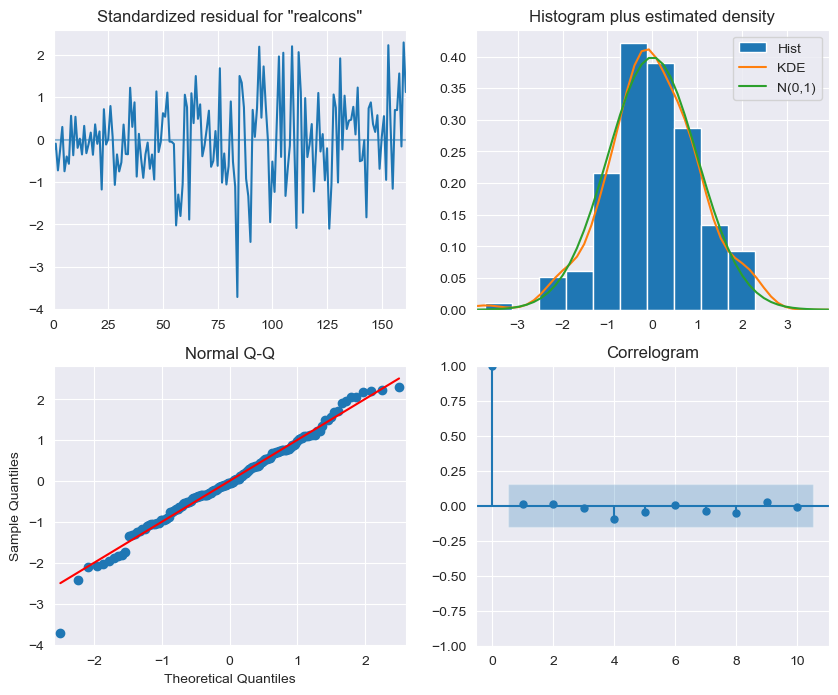

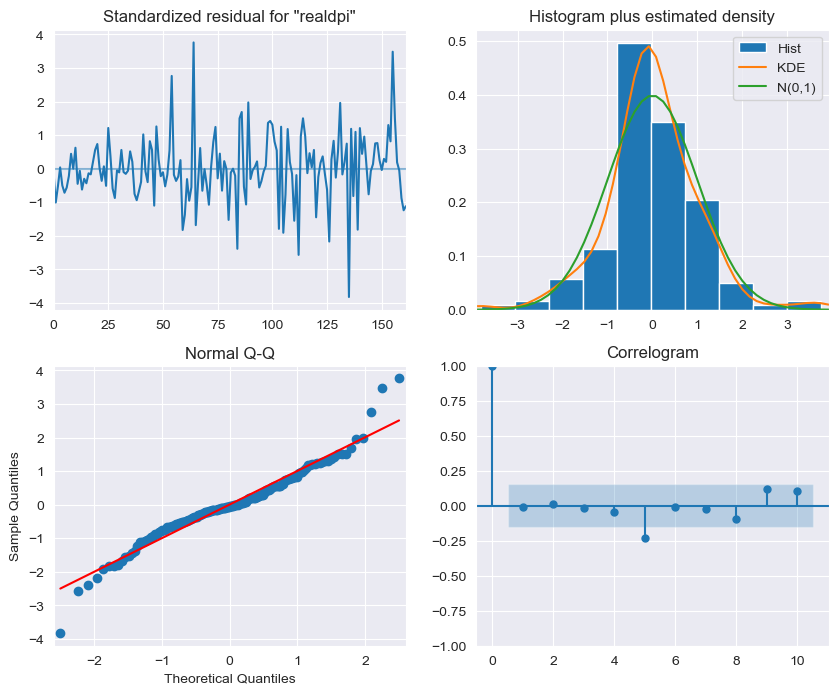

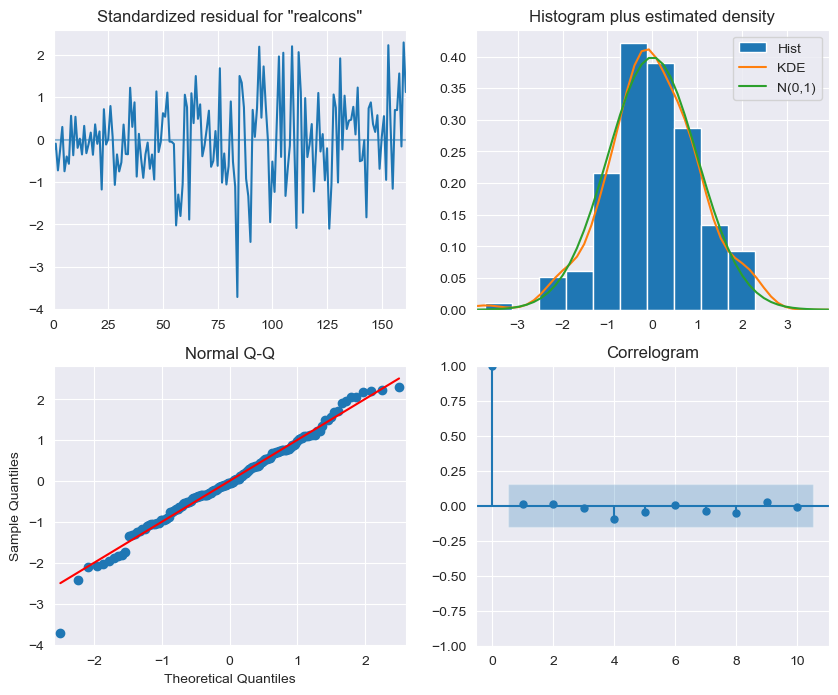

In [8]:
best_model = VARMAX(train, order=(3,0))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0)  #variable 0 is realdpi
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1)  #variable 0 is realcons

In [9]:
realgdp_residuals = best_model_fit.resid['realdpi']
res1 = acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))
print(res1)
realcons_residuals = best_model_fit.resid['realcons']
res2 = acorr_ljungbox(realcons_residuals, np.arange(1, 11, 1))
print(res2)

      lb_stat  lb_pvalue
1    0.011640   0.914085
2    0.029399   0.985408
3    0.075826   0.994571
4    0.377929   0.984244
5    9.142510   0.103513
6    9.165345   0.164490
7    9.270093   0.233842
8   10.811529   0.212609
9   13.318064   0.148734
10  15.287317   0.121933
     lb_stat  lb_pvalue
1   0.023877   0.877199
2   0.068712   0.966228
3   0.068789   0.995299
4   0.235715   0.993577
5   0.377765   0.995920
6   0.787312   0.992410
7   1.015247   0.994579
8   2.150387   0.976051
9   2.437080   0.982528
10  2.442746   0.991684


every p value is above 0.05. we therefore cannot reject null Hypothesis 

In [10]:
def recursive_forecast(_df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'VAR':

        _realdpi_pred_VAR = []
        _realcons_pred_VAR = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(_df[:i], order=(3,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            
            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']
            
            _realdpi_pred_VAR.extend(oos_pred_realdpi)
            _realcons_pred_VAR.extend(oos_pred_realcons)
        
        return realdpi_pred_VAR, realcons_pred_VAR
    
    elif method == 'last':
        _realdpi_pred_last = []
        _realcons_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            realdpi_last = _df[:i].iloc[-1]['realdpi']
            realcons_last = _df[:i].iloc[-1]['realcons']
            
            _realdpi_pred_last.extend(realdpi_last for _ in range(window))
            _realcons_pred_last.extend(realcons_last for _ in range(window))
            
        return _realdpi_pred_last, _realcons_pred_last

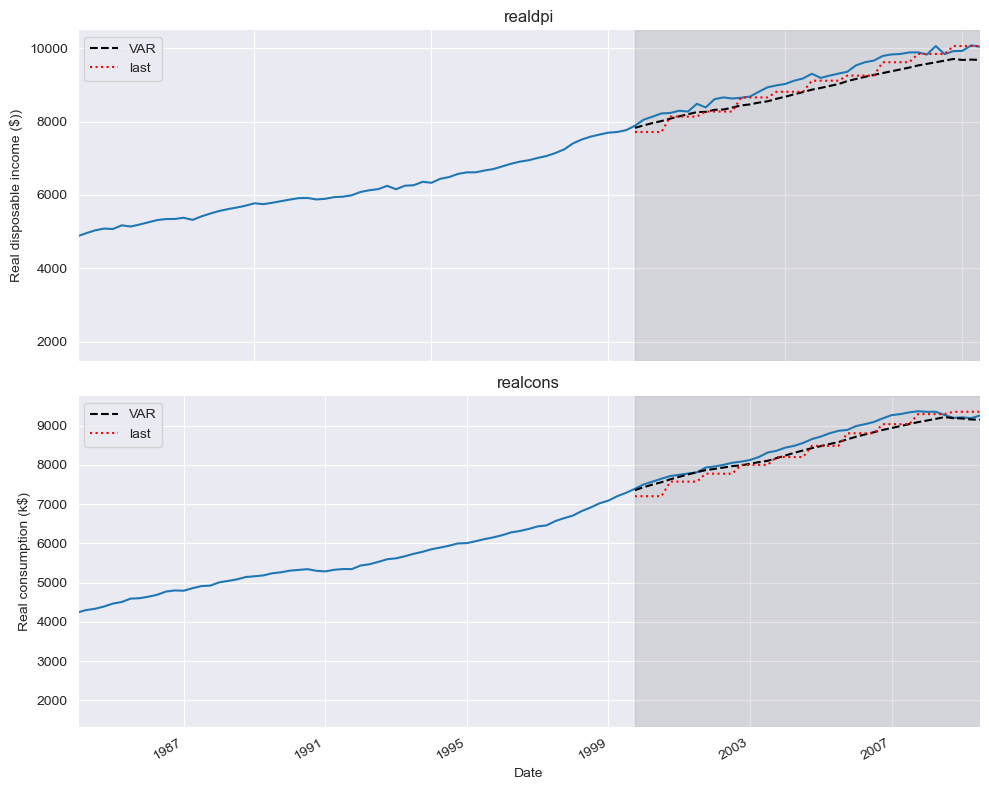

In [11]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

realdpi_pred_VAR, realcons_pred_VAR = recursive_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VAR')
test = endogenous[163:]
test['realdpi_pred_VAR'] = pd.Series()
test['realdpi_pred_VAR'] = endogenous.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VAR)
test['realcons_pred_VAR'] = pd.Series()
test['realcons_pred_VAR'] = endogenous.iloc[162]['realcons'] + np.cumsum(realcons_pred_VAR)

realdpi_pred_last, realcons_pred_last = recursive_forecast(endogenous, TRAIN_LEN, HORIZON, WINDOW, 'last')
test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.plot(test['realdpi_pred_VAR'], 'k--', label='VAR')
ax1.plot(test['realdpi_pred_last'], 'r:', label='last')
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income ($))')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(163, 202, color='#808080', alpha=0.2)
ax1.set_xlim(100, 202)
ax1.legend(loc=2)

ax2.plot(macro_econ_data['realcons'])
ax2.plot(test['realcons_pred_VAR'], 'k--', label='VAR')
ax2.plot(test['realcons_pred_last'], 'r:', label='last')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(163, 202, color='#808080', alpha=0.2)
ax2.set_xlim(100, 202)
ax2.legend(loc=2)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
plt.xlim(100, 202)

fig.autofmt_xdate()
plt.tight_layout()

In [12]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

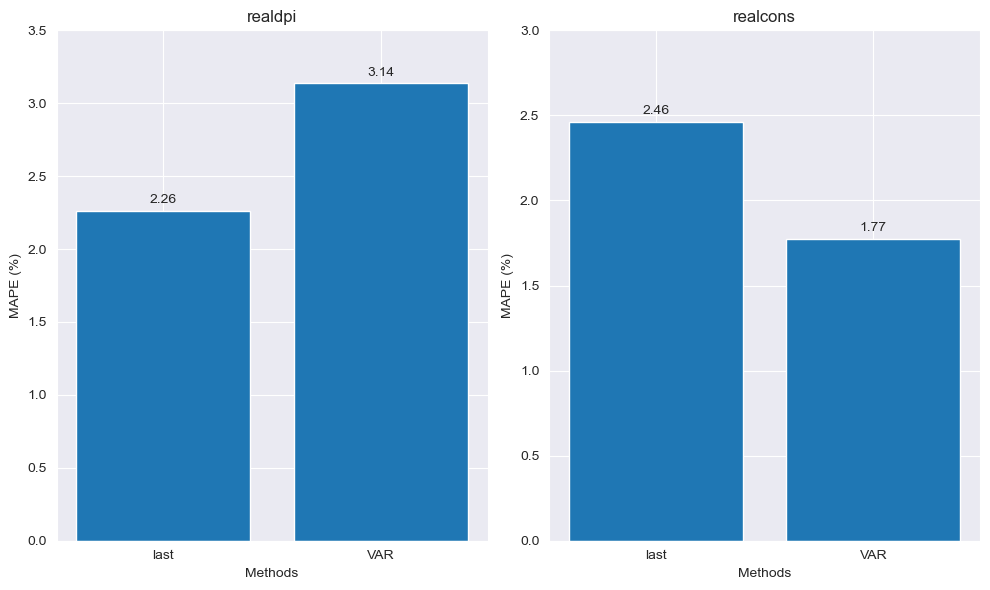

In [13]:
mape_realdpi_VAR = mape(test['realdpi'], test['realdpi_pred_VAR'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VAR = mape(test['realcons'], test['realcons_pred_VAR'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VAR']
y1 = [mape_realdpi_last, mape_realdpi_VAR]
y2 = [mape_realcons_last, mape_realcons_VAR]

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 3.5)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 3)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
    
for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

that is inconclusive because not better both ways than naive last value 

# Full project

In [14]:
df = pd.read_csv('../data/AusAntidiabeticDrug.csv')
df

,ds,y
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
...,...,...
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510


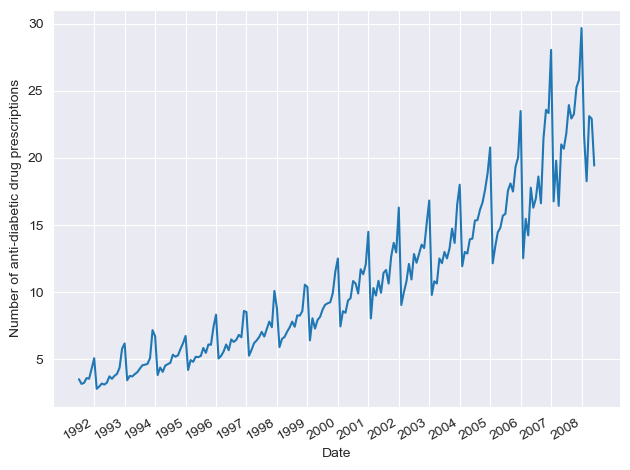

In [15]:
fig, ax = plt.subplots()

ax.plot(df.y)
ax.set_xlabel('Date')
ax.set_ylabel('Number of anti-diabetic drug prescriptions')

plt.xticks(np.arange(6, 203, 12), np.arange(1992, 2009, 1))
fig.autofmt_xdate()
plt.tight_layout()

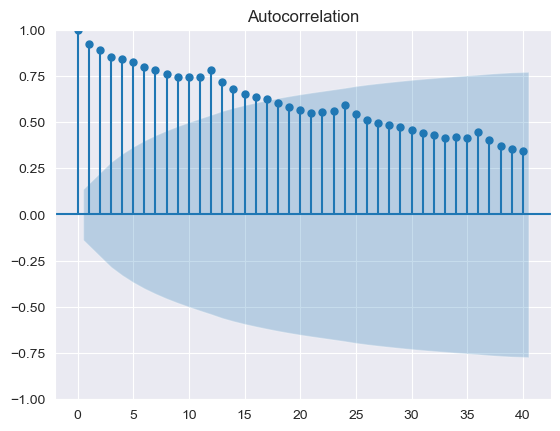

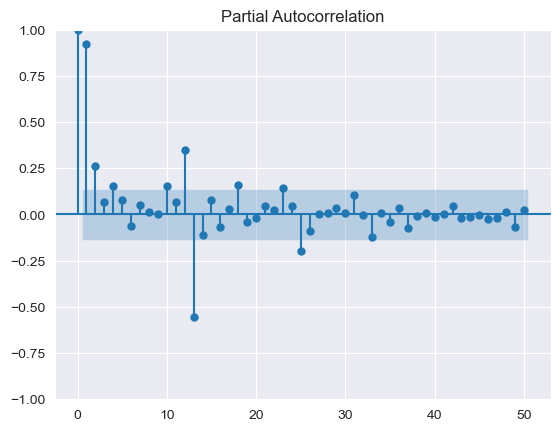

In [16]:
lag_acf = plot_acf(df['y'], lags=40)
lag_pacf = plot_pacf(df['y'], lags=50)

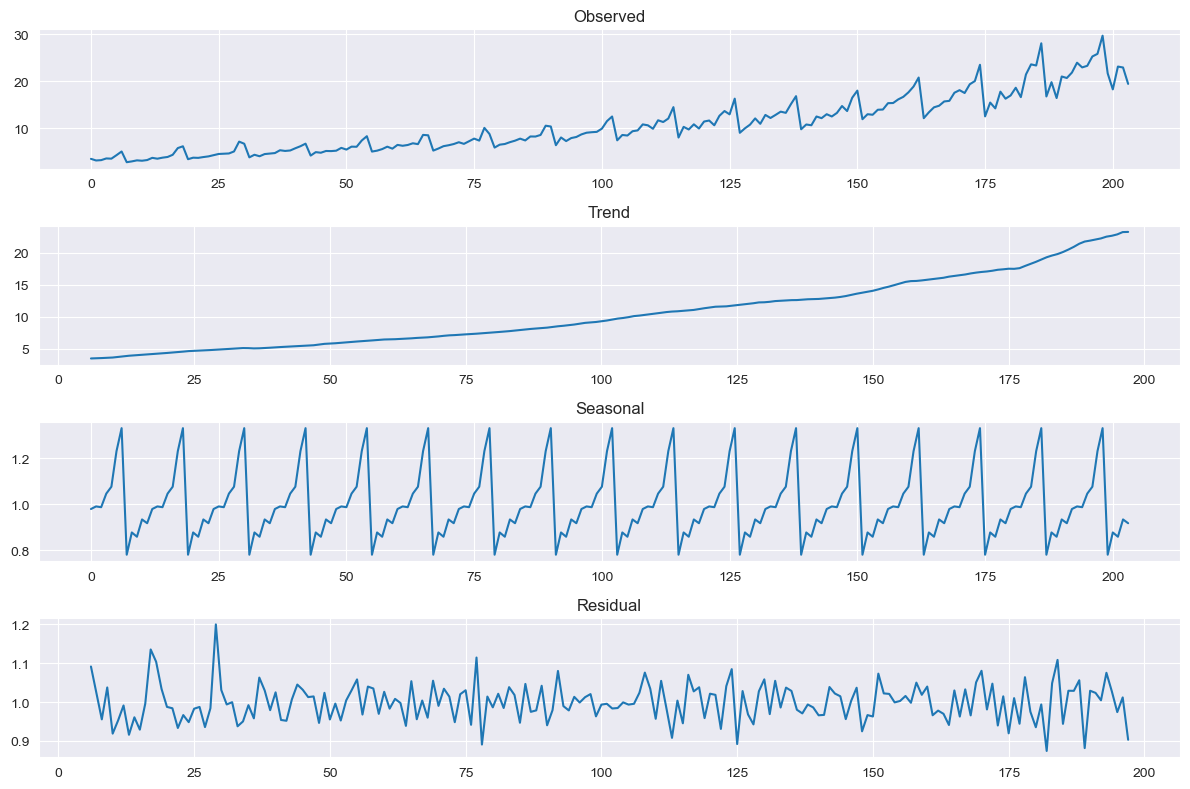

In [17]:
decomposition = seasonal_decompose(df['y'], model='multiplicative',period=12)

fig, axes = plt.subplots(4, 1, figsize=(12, 8))
decomposition.observed.plot(ax=axes[0], legend=False, title='Observed')
decomposition.trend.plot(ax=axes[1], legend=False, title='Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False, title='Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False, title='Residual')

plt.tight_layout()

In [18]:
y_diff_seasonal_diff = np.diff(df.y, n=12)

ad_fuller_result = adfuller(y_diff_seasonal_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')



ADF Statistic: -18.77966995326352
p-value: 2.024364809579715e-30


In [19]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
def fit_model(endog, order, _s):
    try:
        model = SARIMAX(
            endog, 
            order=(order[0], order[1], order[2]),
            seasonal_order=(order[3], order[4], order[5], _s),
            simple_differencing=False).fit(disp=False)
        return [order, model.aic]
    except Exception as e:
        print(f"Error with order {order}: {e}")
        return None
    
def optimize_SARIMA2(endog: pd.Series, _order_list: list, _s: int, max_workers=None) -> pd.DataFrame:
    results = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(fit_model, endog, order, _s): order for order in _order_list}
        for future in tqdm(as_completed(futures), total=len(_order_list)):
            result = future.result()
            if result:
                results.append(result)

    if not results:
        print("No successful model fits found.")
        return pd.DataFrame()
    
    _result_df = pd.DataFrame(results, columns=['(p,d,q,P,D,Q)', 'AIC'])
    result_df_loc = _result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df_loc


# noinspection PyPep8Naming
def optimize_SARIMA(endog: Union[pd.Series, list], _order_list: list, _d: int, _D: int, _s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(_order_list):
        # noinspection PyBroadException
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], _d, order[1]),
                seasonal_order=(order[2], _D, order[3], _s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df_local = pd.DataFrame(results)
    result_df_local.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df_final = result_df_local.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df_final

In [20]:
train = df.y[:168]
test = df.y[168:]

In [22]:
ps = range(0, 5, 1)
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Qs = range(0, 5, 1)

order_list = list(product(ps, qs, Ps, Qs))



d = 1
D = 1
s = 12
SARIMA_result_df = optimize_SARIMA(train, order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/625 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 1, 1, 3)",270.951096
1,"(2, 4, 1, 3)",271.217079
2,"(3, 3, 1, 3)",271.351859
3,"(4, 1, 1, 3)",272.145293
4,"(0, 4, 1, 3)",272.152379
...,...,...
619,"(0, 0, 0, 4)",351.680917
620,"(0, 0, 2, 4)",353.227960
621,"(0, 0, 0, 1)",354.751719
622,"(0, 0, 1, 0)",357.173706


In [21]:
ps = range(0, 5, 1)
ds = range(0, 2, 1)
qs = range(0, 5, 1)
Ps = range(0, 5, 1)
Ds = range(0, 2, 1)
Qs = range(0, 5, 1)
order_list2 = list(product(ps, ds, qs, Ps,Ds, Qs))
s=12
SARIMA_result_df2 = optimize_SARIMA2(train, order_list2, s, max_workers=10)  # Example with 10 threads
SARIMA_result_df2

  2%|▏         | 42/2500 [03:51<4:16:21,  6.26s/it]

Error with order (0, 0, 0, 4, 0, 2): LU decomposition error.


  3%|▎         | 82/2500 [07:27<8:11:51, 12.20s/it]

Error with order (0, 0, 1, 3, 0, 1): LU decomposition error.


  4%|▎         | 88/2500 [08:11<5:41:15,  8.49s/it]

Error with order (0, 0, 1, 4, 0, 2): LU decomposition error.


  8%|▊         | 191/2500 [22:54<7:38:56, 11.93s/it] 

Error with order (0, 0, 3, 4, 0, 4): LU decomposition error.


  9%|▉         | 234/2500 [30:08<7:58:00, 12.66s/it] 

Error with order (0, 0, 4, 4, 0, 0): LU decomposition error.


 26%|██▋       | 660/2500 [1:23:03<2:28:36,  4.85s/it]

Error with order (1, 0, 3, 1, 0, 2): LU decomposition error.


 31%|███       | 781/2500 [1:43:28<3:07:49,  6.56s/it] 

Error with order (1, 1, 0, 2, 1, 3): LU decomposition error.


 46%|████▋     | 1159/2500 [2:39:35<3:09:20,  8.47s/it]

Error with order (2, 0, 3, 1, 0, 2): LU decomposition error.


 48%|████▊     | 1210/2500 [2:49:58<1:57:55,  5.48s/it]

Error with order (2, 0, 4, 1, 0, 2): LU decomposition error.


 61%|██████    | 1525/2500 [3:44:47<1:34:27,  5.81s/it]

Error with order (3, 0, 0, 1, 1, 2): LU decomposition error.


 84%|████████▍ | 2107/2500 [5:43:09<1:12:08, 11.01s/it]

Error with order (4, 0, 2, 1, 0, 2): LU decomposition error.


100%|██████████| 2500/2500 [7:20:09<00:00, 10.56s/it]  


,"(p,d,q,P,D,Q)",AIC
0,"(1, 0, 0, 1, 1, 2)",10.000000
1,"(2, 1, 3, 1, 0, 0)",14.000000
2,"(3, 0, 4, 1, 0, 2)",22.000000
3,"(4, 0, 1, 4, 1, 2)",23.820232
4,"(2, 1, 4, 2, 0, 4)",32.305768
...,...,...
2484,"(0, 0, 0, 0, 0, 2)",913.419909
2485,"(0, 0, 2, 0, 0, 0)",927.403202
2486,"(0, 0, 0, 0, 0, 1)",1058.201209
2487,"(0, 0, 1, 0, 0, 0)",1060.106998


In [23]:
SARIMA_model = SARIMAX(train, order=(2,1,3), seasonal_order=(1,1,3,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)
print(SARIMA_model_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  168
Model:             SARIMAX(2, 1, 3)x(1, 1, 3, 12)   Log Likelihood                -128.117
Date:                            Sat, 25 Nov 2023   AIC                            276.234
Time:                                    06:22:02   BIC                            306.669
Sample:                                         0   HQIC                           288.596
                                            - 168                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1310      0.055    -20.689      0.000      -1.238      -1.024
ar.L2         -0.9657      0.064   